In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import torch.optim as optim
# trochvision is part of PyTorch consisting of models and datasets for computer vision
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import vgg16

In [2]:
# Install the Cleverhans library (provides adversarial attacks)
!pip install -qq git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 14.3 MB/s eta 0:00:00


In [3]:
# Import FGMS and PGD attacks
import cleverhans

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent

In [14]:
# Uncompress the dataset
!unzip -uq "/content/Paintings.zip" -d "sample_data/"

In [15]:
class MyDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, 'images')
        self.labels_file = pd.read_csv(os.path.join(root_dir, 'labels.csv'), header=None)
        self.transform = transform

    def __len__(self):
        return len(self.labels_file)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, f'img_{idx + 1:04}.jpg')
        image = Image.open(img_name)
        image = self.transform(image)
        label = self.labels_file.iloc[idx, 0]

        return image, label

In [16]:
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

dataset = MyDataset(root_dir='/content/sample_data/Paintings', transform=transform)

print(len(dataset))

3988


In [17]:
# Split the dataset into train and test subsets
train_indices_1, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=123)

# Split the dataset into train and validation subsets
train_indices, val_indices = train_test_split(train_indices_1, test_size=0.2, random_state=123)

In [18]:
# Create training, testing, and validation subsets
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
val_dataset = Subset(dataset, val_indices)

In [19]:
# Create training, testing, and validation dataloaders for iterating over the datasets
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=16)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=16)

In [20]:
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

2552
798
638


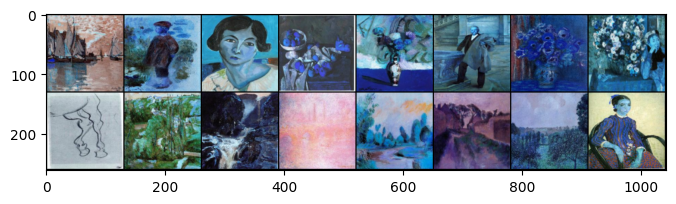

In [21]:
# show several images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get a batch of random training images and labels
images, labels = next(iter(train_dataloader))

# show images
plt.figure(figsize=(8,8))
imshow(torchvision.utils.make_grid(images))

# Model Training and Validation

In [22]:
# Import pretrained VGG16
VGG16 = vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 222MB/s]


In [23]:
# Change the output in the last layer to 10 classes
VGG16.classifier._modules['6'] = nn.Sequential(nn.Linear(4096, 4096), nn.ReLU(True), nn.Dropout(0.5), nn.Linear(4096, 10))

In [24]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [25]:
# Move the model to the GPU
VGG16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
# function to train the model for one epoch on the given set
def train(model, train_loader, criterion, optimizer, epoch):
    running_loss, total, sum_correct = 0.0, 0, 0

    # indicate this is a training step
    model.train()

    for i, data in enumerate(train_loader):
        images, labels = data
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)

        # forward + loss + backward + update
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        sum_correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # return the accuracy and loss
    return sum_correct/total, running_loss


# function to evaluate the model on the given set
def validate(model, val_loader, criterion):
    running_loss, total, sum_correct = 0.0, 0, 0

    # indicate this is an evaluation step
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor)
            images, labels = images.to(device), labels.to(device)

            # Compute the output: forward pass only
            outputs = model(images)
            loss = criterion(outputs, labels)

            # calculate loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            sum_correct += (predicted == labels).sum().item()

    # return the accuracy and loss
    return sum_correct/total, running_loss

In [27]:
# training loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(VGG16.parameters(), lr=0.00001, weight_decay=0.01)

In [28]:
# total number of training epochs
epoch_num = 30

# initialize variables to save the training and validation loss and accuracy
training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []

import datetime
now = datetime.datetime.now
t = now()

# loop over the number of epochs
for epoch in range(epoch_num):

    # train for one epoch: return accuracy and loss
    tr_accuracy, tr_loss = train(VGG16, train_dataloader, criterion, optimizer, epoch)

    # evaluate after each epoch: return accuracy and loss
    val_accuracy, val_loss = validate(VGG16, val_dataloader, criterion)

    # append the accuracies and losses after each epoch
    training_accuracy_plot.append(tr_accuracy)
    training_loss_plot.append(tr_loss)
    val_accuracy_plot.append(val_accuracy)
    val_loss_plot.append(val_loss)

    # Display after each epoch
    print(f'Epoch: {epoch + 1}/{epoch_num}\t Training loss: {tr_loss:.3f}\t',
              f'Training accuracy: {100*tr_accuracy:2.3f}\t Validation accuracy: {100*val_accuracy:2.3f}')

print('Training time: %s' % (now() - t))

Epoch: 1/30	 Training loss: 329.106	 Training accuracy: 23.472	 Validation accuracy: 44.984
Epoch: 2/30	 Training loss: 233.320	 Training accuracy: 48.746	 Validation accuracy: 57.210
Epoch: 3/30	 Training loss: 175.254	 Training accuracy: 62.735	 Validation accuracy: 61.599
Epoch: 4/30	 Training loss: 134.173	 Training accuracy: 71.748	 Validation accuracy: 65.517
Epoch: 5/30	 Training loss: 102.094	 Training accuracy: 78.801	 Validation accuracy: 65.831
Epoch: 6/30	 Training loss: 74.710	 Training accuracy: 83.817	 Validation accuracy: 68.495
Epoch: 7/30	 Training loss: 57.853	 Training accuracy: 88.245	 Validation accuracy: 66.928
Epoch: 8/30	 Training loss: 37.490	 Training accuracy: 92.241	 Validation accuracy: 66.614
Epoch: 9/30	 Training loss: 27.524	 Training accuracy: 94.475	 Validation accuracy: 70.376
Epoch: 10/30	 Training loss: 19.854	 Training accuracy: 96.160	 Validation accuracy: 71.160
Epoch: 11/30	 Training loss: 14.550	 Training accuracy: 97.296	 Validation accuracy:

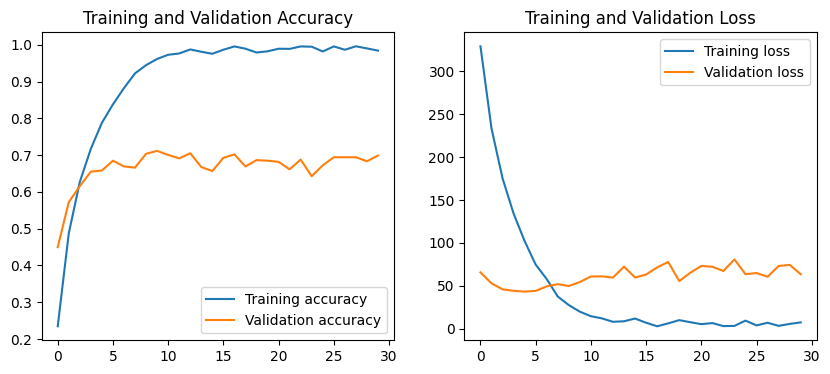

In [29]:
# plot the accuracy and loss for the training and validation datasets
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(training_accuracy_plot)
plt.plot(val_accuracy_plot)
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(training_loss_plot)
plt.plot(val_loss_plot)
plt.legend(['Training loss', 'Validation loss'])
plt.title('Training and Validation Loss')
plt.show()

In [30]:
# calculate the accuracy and loss on the test dataset
test_accuracy, test_loss = validate(VGG16, test_dataloader, criterion)
print(f'Test dataset accuracy: {100*test_accuracy:2.3f}')

Test dataset accuracy: 70.426


### Model Report

| Model | Training Accuracy | Val Accuracy | Test Accuracy |
| --- | --- | ---- | --- |
| VGG16 | 98.43 | 69.91 | 70.43 |

# Generate Advesarial Examples with FGMS

In [31]:
def generate_fgsm_adversarial_examples(model, images, labels, epsilon):
  # FSGM
  adversarial_images = fast_gradient_method(VGG16, images, epsilon, np.inf)
  outputs = VGG16(adversarial_images)
  adversarial_images = torch.clamp(adversarial_images, 0, 1)

  return adversarial_images.detach()

In [32]:
# Generate FGSM adversarial examples on the test dataset
adv_images_list = []
labels_list = []

for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Generate FGSM adversarial examples using the provided function
        adv_images = generate_fgsm_adversarial_examples(VGG16, images, labels, epsilon=10/255.)

        # Append images and labels
        adv_images_list.append(adv_images.detach().cpu())
        labels_list.append(labels.cpu())

# Convert lists to tensors
adv_images_tensor = torch.cat(adv_images_list, dim=0)
adv_labels_tensor = torch.cat(labels_list, dim=0)
print(adv_images_tensor.shape)
print(adv_labels_tensor.shape)

torch.Size([798, 3, 128, 128])
torch.Size([798])


In [33]:
# Create a dataset from tensors
fgsm_adv_dataset = TensorDataset(adv_images_tensor, adv_labels_tensor)

# Create a DataLoader
fgsm_adv_dataloader = DataLoader(fgsm_adv_dataset, batch_size=64, shuffle=False)

In [34]:
# calculate the accuracy of the FGSM attack on test dataset
test_accuracy, test_loss = validate(VGG16, fgsm_adv_dataloader, criterion)
print(f'FGSM adversarial examples accuracy: {100*test_accuracy:2.3f}')

FGSM adversarial examples accuracy: 13.033


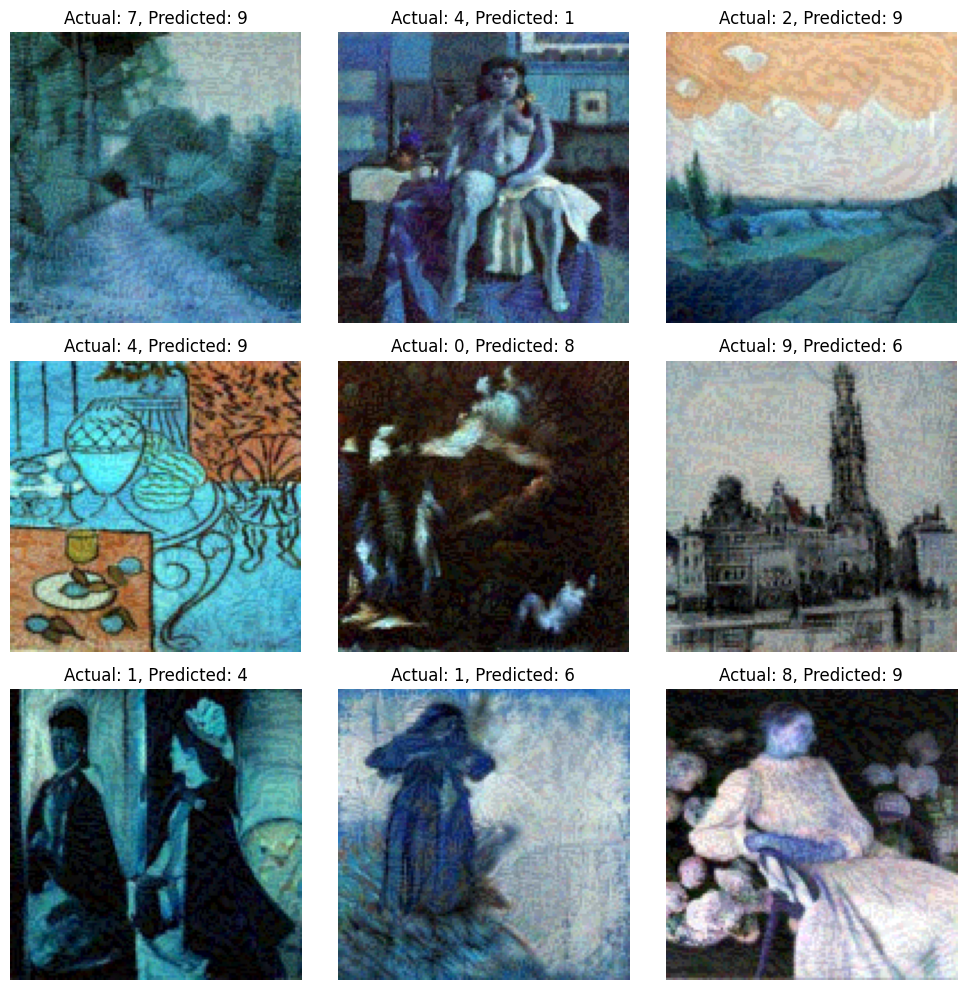

In [35]:
# FGSM - image plot

plt.figure(figsize=(10, 10))
cnt = 1

for i in range(9):
    images, labels = next(iter(fgsm_adv_dataloader))
    images = images.cuda()
    labels = labels.cuda()

    outputs = VGG16(images)
    _, predicted = torch.max(outputs.data, 1)

    plt.subplot(3, 3, cnt)

    # Display image
    img = images[i].cpu().detach().numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)

    # Set title with predicted and actual labels
    actual_label = labels[i].item()
    predicted_label = predicted[i].item()
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")

    plt.axis('off')
    cnt += 1

plt.tight_layout()
plt.show()

# Generate Adversarial Examples with PGD

In [36]:
# PGD
def generate_pgd_adversarial_examples(model, images, labels, epsilon=10/255., alpha=0.01, iters=10, random_start=True):
  adversarial_images = projected_gradient_descent(model_fn = VGG16, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter=60, norm = np.inf)
  outputs = VGG16(adversarial_images)
  adversarial_images = torch.clamp(adversarial_images, 0, 1)

  return adversarial_images.detach()

In [37]:
# use a subset fo 200 images for the PGD attack
sub_dataset = Subset(test_dataset, list(range(200)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

In [38]:
# Generate PGD adversarial examples on the subset of 200 images
adv_images_list = []
labels_list = []

for images, labels in subsest_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Generate PGD adversarial examples using the provided function
        adv_images = generate_pgd_adversarial_examples(VGG16, images, labels, epsilon=10/255., alpha=0.01, iters=10, random_start=True)

        # Append images and labels
        adv_images_list.append(adv_images.detach().cpu())
        labels_list.append(labels.cpu())

# Convert lists to tensors
adv_images_tensor = torch.cat(adv_images_list, dim=0)
adv_labels_tensor = torch.cat(labels_list, dim=0)

In [39]:
# Create a dataset from tensors
pgd_adv_dataset = TensorDataset(adv_images_tensor, adv_labels_tensor)

# Create a DataLoader
pgd_adv_dataloader = DataLoader(pgd_adv_dataset, batch_size=64, shuffle=False)

In [40]:
# calculate the accuracy of the PGD attack on test dataset
test_accuracy, test_loss = validate(VGG16, pgd_adv_dataloader, criterion)
print(f'PGD adversarial examples accuracy: {100*test_accuracy:2.3f}')

PGD adversarial examples accuracy: 12.000


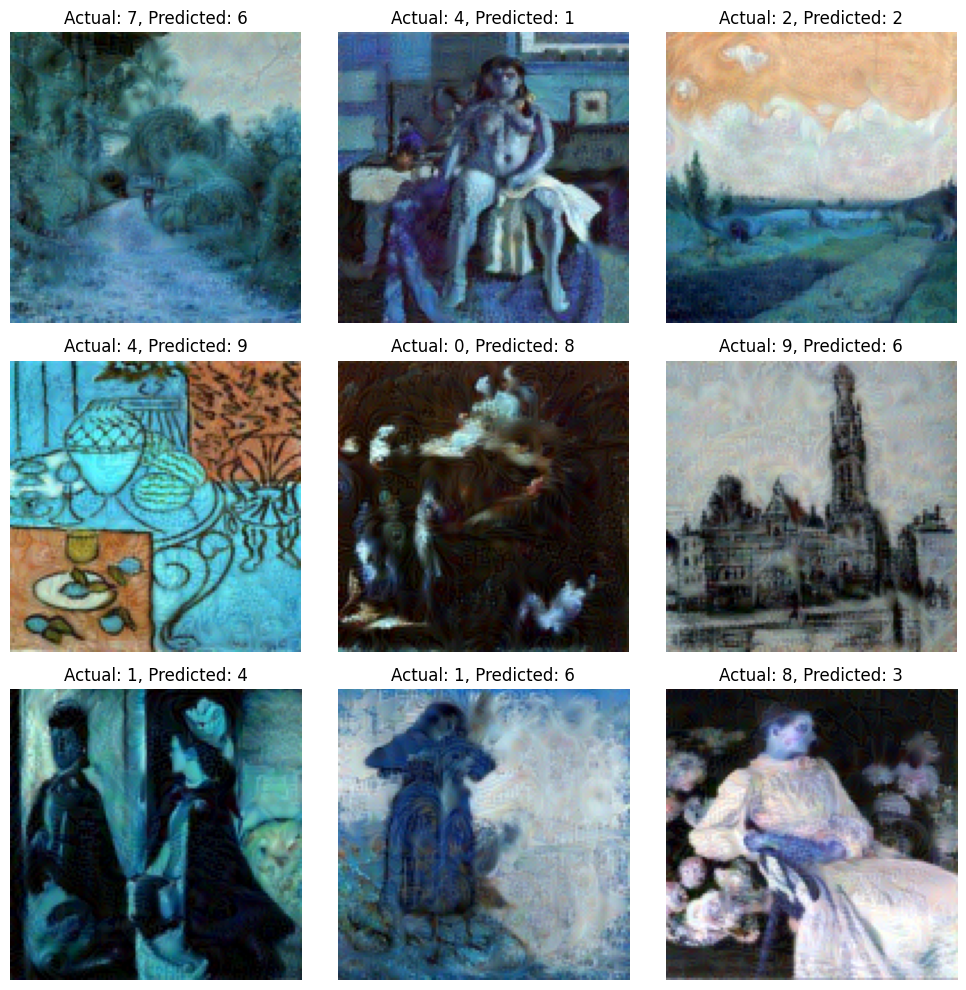

In [41]:
# PGD - image plot

plt.figure(figsize=(10, 10))
cnt = 1

for i in range(9):
    images, labels = next(iter(pgd_adv_dataloader))
    images = images.cuda()
    labels = labels.cuda()

    outputs = VGG16(images)
    _, predicted = torch.max(outputs.data, 1)

    plt.subplot(3, 3, cnt)

    # Display image
    img = images[i].cpu().detach().numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)

    # Set title with predicted and actual labels
    actual_label = labels[i].item()
    predicted_label = predicted[i].item()
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")

    plt.axis('off')
    cnt += 1

plt.tight_layout()
plt.show()

# Adversarial Training

In [42]:
# Function to perform adversarial training with FGSM examples
def adversarial_training(model, train_loader, optimizer, epochs, epsilon):

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Generate FGSM adversarial examples
            adv_images = generate_fgsm_adversarial_examples(model, images, labels, epsilon)

            # Mix clean and adversarial examples
            mixed_images = torch.cat([images, adv_images], dim=0)
            mixed_labels = torch.cat([labels, labels], dim=0)

            # forward + loss + backward + update
            outputs = model(mixed_images)
            loss = criterion(outputs, mixed_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")

In [43]:
# Advsarial training
optimizer = optim.Adam(VGG16.parameters(), lr=1e-5)
t = now()
adversarial_training(VGG16, train_dataloader, optimizer, epochs=30, epsilon=10/255.)
print('Time for adversarial training: %s' % (now() - t))

Epoch [1/30], Loss: 1.4772
Epoch [2/30], Loss: 1.1732
Epoch [3/30], Loss: 1.0791
Epoch [4/30], Loss: 0.9368
Epoch [5/30], Loss: 0.8310
Epoch [6/30], Loss: 0.7023
Epoch [7/30], Loss: 0.6063
Epoch [8/30], Loss: 0.5503
Epoch [9/30], Loss: 0.5175
Epoch [10/30], Loss: 0.4466
Epoch [11/30], Loss: 0.4381
Epoch [12/30], Loss: 0.3818
Epoch [13/30], Loss: 0.3434
Epoch [14/30], Loss: 0.3125
Epoch [15/30], Loss: 0.2963
Epoch [16/30], Loss: 0.3190
Epoch [17/30], Loss: 0.2788
Epoch [18/30], Loss: 0.2626
Epoch [19/30], Loss: 0.2513
Epoch [20/30], Loss: 0.2160
Epoch [21/30], Loss: 0.2195
Epoch [22/30], Loss: 0.2232
Epoch [23/30], Loss: 0.2277
Epoch [24/30], Loss: 0.2852
Epoch [25/30], Loss: 0.1832
Epoch [26/30], Loss: 0.1549
Epoch [27/30], Loss: 0.1612
Epoch [28/30], Loss: 0.1730
Epoch [29/30], Loss: 0.1657
Epoch [30/30], Loss: 0.1791
Time for adversarial training: 0:17:33.270377


In [44]:
# calculate the accuracy on the clean train dataset
test_accuracy, test_loss = validate(VGG16, train_dataloader, criterion)
print(f'Clean train dataset accuracy: {100*test_accuracy:2.3f}')

Clean train dataset accuracy: 99.726


In [45]:
# calculate the accuracy on the clean test dataset
test_accuracy, test_loss = validate(VGG16, test_dataloader, criterion)
print(f'Clean test dataset accuracy: {100*test_accuracy:2.3f}')

Clean test dataset accuracy: 66.667


In [46]:
# calculate the accuracy on the FGSM adversarial exmaples
test_accuracy, test_loss = validate(VGG16, fgsm_adv_dataloader, criterion)
print(f'FGSM adversarial examples accuracy accuracy: {100*test_accuracy:2.3f}')

FGSM adversarial examples accuracy accuracy: 60.025


In [47]:
# calculate the accuracy on the PGD adversarial exmaples
test_accuracy, test_loss = validate(VGG16, pgd_adv_dataloader, criterion)
print(f'PGD adversarial examples accuracy accuracy: {100*test_accuracy:2.3f}')

PGD adversarial examples accuracy accuracy: 18.500


### Adversarial Training Report

|  | Accuracy on test dataset | Accuracy on FGSM attacked subset of test images | Accuracy on PGD attack subset of 200 images |
| --- | --- | --- | --- |
| Standard Classifier | 70.43 | 13.03 | 12.00 |
| Adversarially trained classifier | 66.67 | 60.03 | 18.50 |

Smaller perturbations will allow for the model to train quicker, but will have less of an impact on overall performance when dealing with adversarial attacks. If using a higher perturbation you will probably have a drop off on the accuracry on a clean dataset as shown by the almost 4% drop off already shown. Training with PGD attacks will also take longer, but as a result of using a better adversarial attack will have a better preformance when the model is analyzing adversarial attacks.